**Library Import**

In [1]:
import os
import cv2
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets import register_coco_instances
import matplotlib.pyplot as plt

**prepare the dataset**

In [ ]:
import json

# Load both JSON files
with open("/home/gs285/AIPI_HW/Faster RCNN/annotations_COCO/laptop_annotation.json") as f:
    data_1 = json.load(f)

with open("/home/gs285/AIPI_HW/Faster RCNN/annotations_COCO/mouse_keyboard_annotation.json") as f:
    data_2 = json.load(f)

# Step 1: Define a consistent category mapping for both files
# We want both JSON files to follow this mapping:
category_mapping = {
    "laptop": 1,
    "keyboard": 2,
    "mouse": 3
}

# Step 2: Remap the category IDs in data_2 to match data_1
for category in data_2['categories']:
    if category['name'] in category_mapping:
        category['id'] = category_mapping[category['name']]

# Step 3: Remap the category IDs in the annotations of data_2
for annotation in data_2['annotations']:
    old_category_id = annotation['category_id']
    # Find the corresponding category name
    category_name = next((cat['name'] for cat in data_2['categories'] if cat['id'] == old_category_id), None)
    if category_name:
        # Update the category ID to match the consistent mapping
        annotation['category_id'] = category_mapping[category_name]

# Step 4: Combine 'images' and 'annotations' from both datasets
combined_data = {
    "licenses": data_1['licenses'],
    "info": data_1['info'],
    "categories": data_1['categories'],  # Use the consistent category mapping
    "images": data_1['images'] + data_2['images'],
    "annotations": data_1['annotations'] + data_2['annotations']
}

# Ensure unique IDs for images and annotations
next_image_id = max([img['id'] for img in combined_data['images']]) + 1
next_annotation_id = max([ann['id'] for ann in combined_data['annotations']]) + 1

# Update image IDs and annotation IDs for data_2
for img in data_2['images']:
    img['id'] = next_image_id
    next_image_id += 1

for ann in data_2['annotations']:
    ann['image_id'] = next_image_id
    ann['id'] = next_annotation_id
    next_annotation_id += 1

# Step 5: Save the combined JSON file
with open("combined_annotations.json", "w") as f:
    json.dump(combined_data, f)

print("Combined JSON file created successfully!")


In [2]:
import json
import os
from sklearn.model_selection import train_test_split

# Load the original COCO annotations JSON file
with open("/home/gs285/AIPI_HW/Faster RCNN/annotations_COCO/laptop_annotation.json") as f:
    coco_data = json.load(f)

# Get all image IDs from the dataset
image_ids = [img['id'] for img in coco_data['images']]

# Split into 80% training and 20% validation
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

def filter_annotations_by_image_ids(coco_data, image_ids):
    # Filter images
    filtered_images = [img for img in coco_data['images'] if img['id'] in image_ids]
    
    # Filter annotations
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    
    # Preserve the other fields (categories, etc.)
    filtered_data = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": coco_data['categories']
    }
    return filtered_data

# Create new JSON files for train and val sets
train_data = filter_annotations_by_image_ids(coco_data, train_ids)
val_data = filter_annotations_by_image_ids(coco_data, val_ids)

# Save the new annotation files
os.makedirs("split_annotation", exist_ok=True)
with open("split_annotation/annotations_train.json", "w") as f:
    json.dump(train_data, f)

with open("split_annotation/annotations_val.json", "w") as f:
    json.dump(val_data, f)


**Visualization during the training phase on validation set**

In [3]:
# Hook to evaluate and visualize the validation set every 100 iterations
class ValidationVisualizationHook(HookBase):
    def __init__(self, cfg, predictor, eval_period=500):
        self.cfg = cfg
        self.predictor = predictor
        self.eval_period = eval_period

    def after_step(self):
        iteration = self.trainer.iter
        if iteration % self.eval_period == 0 and iteration != 0:
            self.visualize_predictions()

    def visualize_predictions(self):
        # Get validation dataset
        dataset_dicts = DatasetCatalog.get(self.cfg.DATASETS.TEST[0])
        metadata = MetadataCatalog.get(self.cfg.DATASETS.TEST[0])

        # Visualize predictions on the first 5 validation images
        for d in dataset_dicts[:5]:
            img = cv2.imread(d["file_name"])
            outputs = self.predictor(img)
            
            # Print predictions to check if the model is producing results
            print("Predictions:", outputs)

            # Visualize the predicted bounding boxes
            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
            out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

            # Convert the visualized output to an image suitable for matplotlib
            result_image = out.get_image()[:, :, ::-1]

            # Display the image using matplotlib
            plt.figure(figsize=(12, 8))
            plt.imshow(result_image)
            plt.axis("off")  # Turn off axis
            plt.show()  # Display the image in the notebook


**Detector Training**

[10/15 01:23:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/15 01:23:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/15 01:23:44 d2.engine.train_loop]: Starting training from iteration 0


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:23:50 d2.utils.events]:  eta: 0:13:08  iter: 19  total_loss: 0.6408  loss_cls: 0.4024  loss_box_reg: 0.145  loss_rpn_cls: 0.008974  loss_rpn_loc: 0.03526    time: 0.2663  last_time: 0.2414  data_time: 0.0108  last_data_time: 0.0038   lr: 0.00025  max_mem: 2708M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:23:56 d2.utils.events]:  eta: 0:13:17  iter: 39  total_loss: 0.4288  loss_cls: 0.1882  loss_box_reg: 0.1743  loss_rpn_cls: 0.007407  loss_rpn_loc: 0.0417    time: 0.2671  last_time: 0.2685  data_time: 0.0040  last_data_time: 0.0040   lr: 0.00025  max_mem: 2708M
[10/15 01:24:01 d2.utils.events]:  eta: 0:13:02  iter: 59  total_loss: 0.3549  loss_cls: 0.1322  loss_box_reg: 0.1685  loss_rpn_cls: 0.004728  loss_rpn_loc: 0.03519    time: 0.2653  last_time: 0.2162  data_time: 0.0039  last_data_time: 0.0010   lr: 0.00025  max_mem: 2709M
[10/15 01:24:06 d2.utils.events]:  eta: 0:13:06  iter: 79  total_loss: 0.3262  loss_cls: 0.1073  loss_box_reg: 0.1444  loss_rpn_cls: 0.006144  loss_rpn_loc: 0.05655    time: 0.2678  last_time: 0.3065  data_time: 0.0039  last_data_time: 0.0038   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:12 d2.utils.events]:  eta: 0:12:58  iter: 99  total_loss: 0.3  loss_cls: 0.1042  loss_box_reg: 0.1502  loss_rpn_cls: 0.00487  loss_rpn_loc: 0.0336    time: 0.2675  last_time: 0.2774  data_time: 0.0040  last_data_time: 0.0039   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:17 d2.utils.events]:  eta: 0:12:58  iter: 119  total_loss: 0.3105  loss_cls: 0.1023  loss_box_reg: 0.1586  loss_rpn_cls: 0.002293  loss_rpn_loc: 0.03587    time: 0.2682  last_time: 0.2376  data_time: 0.0040  last_data_time: 0.0052   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:23 d2.utils.events]:  eta: 0:12:54  iter: 139  total_loss: 0.3685  loss_cls: 0.1127  loss_box_reg: 0.174  loss_rpn_cls: 0.003396  loss_rpn_loc: 0.03347    time: 0.2682  last_time: 0.2501  data_time: 0.0038  last_data_time: 0.0054   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:28 d2.utils.events]:  eta: 0:12:48  iter: 159  total_loss: 0.2729  loss_cls: 0.08037  loss_box_reg: 0.1431  loss_rpn_cls: 0.003599  loss_rpn_loc: 0.0345    time: 0.2682  last_time: 0.2865  data_time: 0.0041  last_data_time: 0.0043   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:33 d2.utils.events]:  eta: 0:12:42  iter: 179  total_loss: 0.3093  loss_cls: 0.0775  loss_box_reg: 0.1674  loss_rpn_cls: 0.004128  loss_rpn_loc: 0.03013    time: 0.2681  last_time: 0.2320  data_time: 0.0039  last_data_time: 0.0030   lr: 0.00025  max_mem: 2709M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:39 d2.utils.events]:  eta: 0:12:36  iter: 199  total_loss: 0.3006  loss_cls: 0.07754  loss_box_reg: 0.1426  loss_rpn_cls: 0.001735  loss_rpn_loc: 0.0501    time: 0.2682  last_time: 0.2264  data_time: 0.0040  last_data_time: 0.0051   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:44 d2.utils.events]:  eta: 0:12:28  iter: 219  total_loss: 0.2997  loss_cls: 0.0919  loss_box_reg: 0.1612  loss_rpn_cls: 0.003523  loss_rpn_loc: 0.03446    time: 0.2675  last_time: 0.2528  data_time: 0.0038  last_data_time: 0.0027   lr: 0.00025  max_mem: 2803M
[10/15 01:24:49 d2.utils.events]:  eta: 0:12:25  iter: 239  total_loss: 0.2648  loss_cls: 0.07539  loss_box_reg: 0.1627  loss_rpn_cls: 0.002468  loss_rpn_loc: 0.02775    time: 0.2680  last_time: 0.2614  data_time: 0.0039  last_data_time: 0.0013   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:24:55 d2.utils.events]:  eta: 0:12:18  iter: 259  total_loss: 0.3132  loss_cls: 0.0788  loss_box_reg: 0.1547  loss_rpn_cls: 0.002279  loss_rpn_loc: 0.03939    time: 0.2679  last_time: 0.2998  data_time: 0.0042  last_data_time: 0.0078   lr: 0.00025  max_mem: 2803M
[10/15 01:25:00 d2.utils.events]:  eta: 0:12:09  iter: 279  total_loss: 0.2492  loss_cls: 0.0625  loss_box_reg: 0.1269  loss_rpn_cls: 0.003795  loss_rpn_loc: 0.03699    time: 0.2678  last_time: 0.2894  data_time: 0.0038  last_data_time: 0.0053   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:06 d2.utils.events]:  eta: 0:12:01  iter: 299  total_loss: 0.2379  loss_cls: 0.06045  loss_box_reg: 0.1487  loss_rpn_cls: 0.001855  loss_rpn_loc: 0.02588    time: 0.2682  last_time: 0.4170  data_time: 0.0106  last_data_time: 0.1393   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:11 d2.utils.events]:  eta: 0:11:56  iter: 319  total_loss: 0.2379  loss_cls: 0.05832  loss_box_reg: 0.1456  loss_rpn_cls: 0.002534  loss_rpn_loc: 0.03107    time: 0.2683  last_time: 0.2658  data_time: 0.0041  last_data_time: 0.0038   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:16 d2.utils.events]:  eta: 0:11:50  iter: 339  total_loss: 0.2169  loss_cls: 0.04376  loss_box_reg: 0.118  loss_rpn_cls: 0.003151  loss_rpn_loc: 0.0289    time: 0.2683  last_time: 0.3080  data_time: 0.0041  last_data_time: 0.0093   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:22 d2.utils.events]:  eta: 0:11:44  iter: 359  total_loss: 0.2531  loss_cls: 0.04723  loss_box_reg: 0.1076  loss_rpn_cls: 0.001848  loss_rpn_loc: 0.03232    time: 0.2687  last_time: 0.3259  data_time: 0.0038  last_data_time: 0.0052   lr: 0.00025  max_mem: 2803M
[10/15 01:25:27 d2.utils.events]:  eta: 0:11:40  iter: 379  total_loss: 0.1819  loss_cls: 0.04802  loss_box_reg: 0.09523  loss_rpn_cls: 0.001834  loss_rpn_loc: 0.02196    time: 0.2685  last_time: 0.2828  data_time: 0.0038  last_data_time: 0.0012   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:33 d2.utils.events]:  eta: 0:11:37  iter: 399  total_loss: 0.2142  loss_cls: 0.05425  loss_box_reg: 0.1134  loss_rpn_cls: 0.002062  loss_rpn_loc: 0.04165    time: 0.2686  last_time: 0.3026  data_time: 0.0039  last_data_time: 0.0025   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:38 d2.utils.events]:  eta: 0:11:32  iter: 419  total_loss: 0.2039  loss_cls: 0.04975  loss_box_reg: 0.1082  loss_rpn_cls: 0.001634  loss_rpn_loc: 0.04872    time: 0.2692  last_time: 0.2678  data_time: 0.0041  last_data_time: 0.0037   lr: 0.00025  max_mem: 2803M
[10/15 01:25:43 d2.utils.events]:  eta: 0:11:26  iter: 439  total_loss: 0.2001  loss_cls: 0.04289  loss_box_reg: 0.09365  loss_rpn_cls: 0.003137  loss_rpn_loc: 0.03277    time: 0.2689  last_time: 0.1958  data_time: 0.0048  last_data_time: 0.0038   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:49 d2.utils.events]:  eta: 0:11:19  iter: 459  total_loss: 0.1754  loss_cls: 0.05009  loss_box_reg: 0.09457  loss_rpn_cls: 0.002069  loss_rpn_loc: 0.02591    time: 0.2684  last_time: 0.2652  data_time: 0.0040  last_data_time: 0.0050   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:25:54 d2.utils.events]:  eta: 0:11:15  iter: 479  total_loss: 0.1694  loss_cls: 0.03491  loss_box_reg: 0.07184  loss_rpn_cls: 0.001008  loss_rpn_loc: 0.0282    time: 0.2686  last_time: 0.2740  data_time: 0.0039  last_data_time: 0.0015   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:00 d2.utils.events]:  eta: 0:11:10  iter: 499  total_loss: 0.1691  loss_cls: 0.04032  loss_box_reg: 0.06946  loss_rpn_cls: 0.001675  loss_rpn_loc: 0.04035    time: 0.2688  last_time: 0.2564  data_time: 0.0040  last_data_time: 0.0051   lr: 0.00025  max_mem: 2803M
[10/15 01:26:00 d2.data.datasets.coco]: Loaded 20 images in COCO format from /home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json
Predictions: {'instances': Instances(num_instances=0, image_height=578, image_width=1028, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


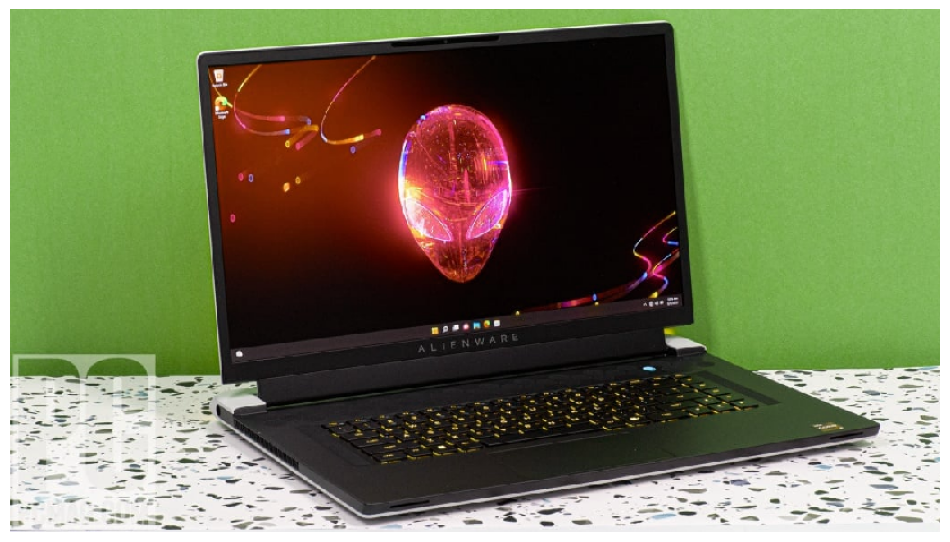

Predictions: {'instances': Instances(num_instances=0, image_height=600, image_width=800, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


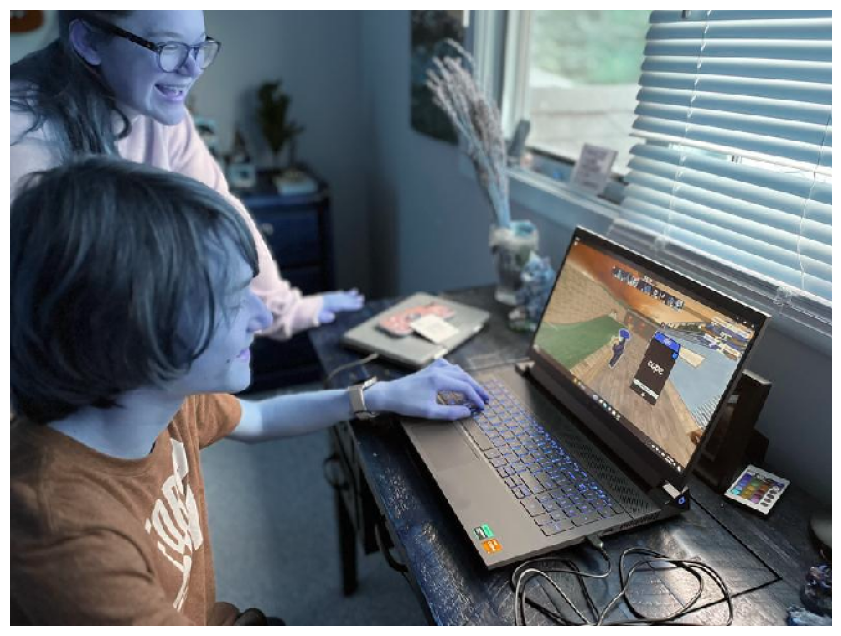

Predictions: {'instances': Instances(num_instances=0, image_height=602, image_width=800, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


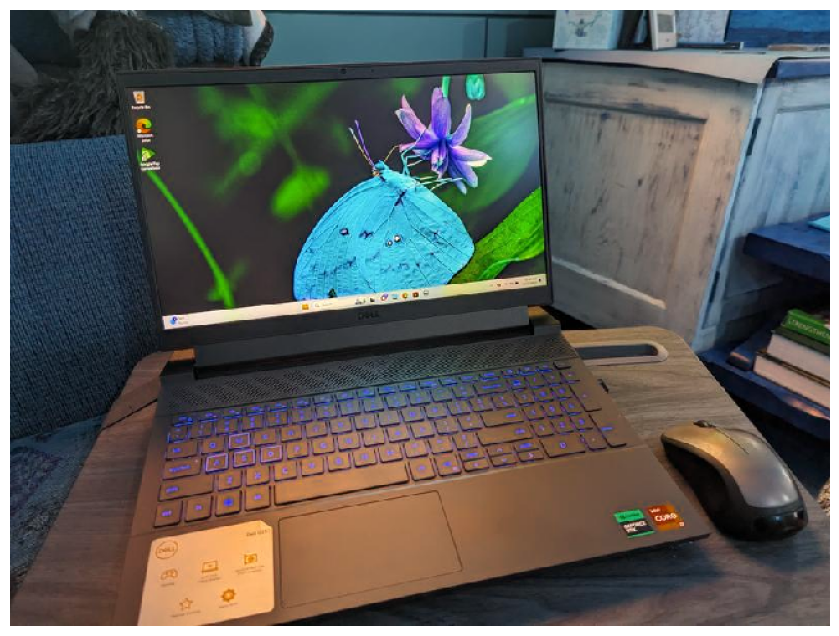

Predictions: {'instances': Instances(num_instances=0, image_height=800, image_width=600, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


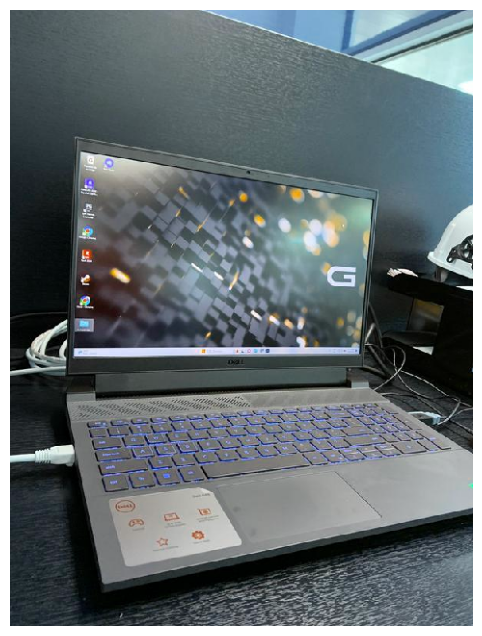

Predictions: {'instances': Instances(num_instances=0, image_height=800, image_width=600, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


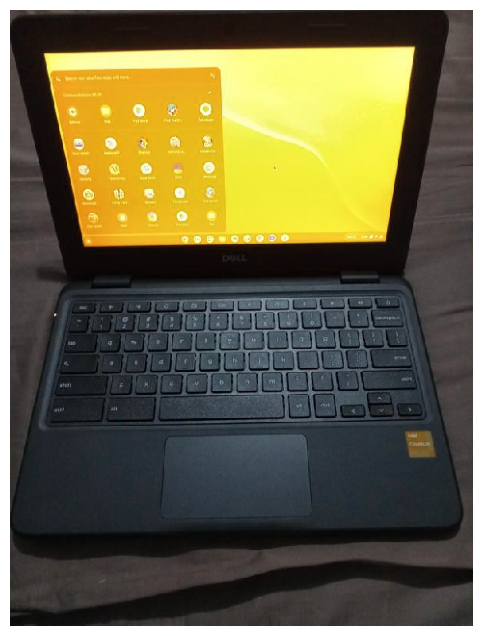

[10/15 01:26:07 d2.utils.events]:  eta: 0:11:05  iter: 519  total_loss: 0.187  loss_cls: 0.03865  loss_box_reg: 0.08079  loss_rpn_cls: 0.001385  loss_rpn_loc: 0.03347    time: 0.2694  last_time: 0.2526  data_time: 0.0039  last_data_time: 0.0057   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:13 d2.utils.events]:  eta: 0:11:00  iter: 539  total_loss: 0.1759  loss_cls: 0.04573  loss_box_reg: 0.0776  loss_rpn_cls: 0.003232  loss_rpn_loc: 0.0401    time: 0.2694  last_time: 0.3085  data_time: 0.0038  last_data_time: 0.0025   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:18 d2.utils.events]:  eta: 0:10:55  iter: 559  total_loss: 0.1368  loss_cls: 0.03348  loss_box_reg: 0.06189  loss_rpn_cls: 0.0008706  loss_rpn_loc: 0.03369    time: 0.2695  last_time: 0.2412  data_time: 0.0039  last_data_time: 0.0038   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:24 d2.utils.events]:  eta: 0:10:50  iter: 579  total_loss: 0.1513  loss_cls: 0.04096  loss_box_reg: 0.08336  loss_rpn_cls: 0.002664  loss_rpn_loc: 0.03311    time: 0.2697  last_time: 0.2872  data_time: 0.0038  last_data_time: 0.0043   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:29 d2.utils.events]:  eta: 0:10:44  iter: 599  total_loss: 0.1383  loss_cls: 0.03198  loss_box_reg: 0.06346  loss_rpn_cls: 0.001224  loss_rpn_loc: 0.03788    time: 0.2697  last_time: 0.2888  data_time: 0.0038  last_data_time: 0.0037   lr: 0.00025  max_mem: 2803M
[10/15 01:26:35 d2.utils.events]:  eta: 0:10:39  iter: 619  total_loss: 0.1417  loss_cls: 0.02961  loss_box_reg: 0.062  loss_rpn_cls: 0.001921  loss_rpn_loc: 0.03756    time: 0.2697  last_time: 0.3038  data_time: 0.0038  last_data_time: 0.0025   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:40 d2.utils.events]:  eta: 0:10:34  iter: 639  total_loss: 0.1538  loss_cls: 0.04406  loss_box_reg: 0.07568  loss_rpn_cls: 0.001047  loss_rpn_loc: 0.03196    time: 0.2696  last_time: 0.2746  data_time: 0.0039  last_data_time: 0.0026   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:45 d2.utils.events]:  eta: 0:10:30  iter: 659  total_loss: 0.1453  loss_cls: 0.0323  loss_box_reg: 0.05676  loss_rpn_cls: 0.001181  loss_rpn_loc: 0.03116    time: 0.2697  last_time: 0.3001  data_time: 0.0040  last_data_time: 0.0010   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:51 d2.utils.events]:  eta: 0:10:25  iter: 679  total_loss: 0.1288  loss_cls: 0.03064  loss_box_reg: 0.07096  loss_rpn_cls: 0.001232  loss_rpn_loc: 0.02281    time: 0.2695  last_time: 0.2183  data_time: 0.0039  last_data_time: 0.0036   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:26:56 d2.utils.events]:  eta: 0:10:20  iter: 699  total_loss: 0.12  loss_cls: 0.02799  loss_box_reg: 0.05872  loss_rpn_cls: 0.002382  loss_rpn_loc: 0.03106    time: 0.2698  last_time: 0.2536  data_time: 0.0127  last_data_time: 0.0040   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:02 d2.utils.events]:  eta: 0:10:14  iter: 719  total_loss: 0.139  loss_cls: 0.03677  loss_box_reg: 0.06825  loss_rpn_cls: 0.00146  loss_rpn_loc: 0.02523    time: 0.2698  last_time: 0.2847  data_time: 0.0039  last_data_time: 0.0039   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:07 d2.utils.events]:  eta: 0:10:09  iter: 739  total_loss: 0.1201  loss_cls: 0.03472  loss_box_reg: 0.05625  loss_rpn_cls: 0.001076  loss_rpn_loc: 0.02945    time: 0.2698  last_time: 0.2762  data_time: 0.0046  last_data_time: 0.0040   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:13 d2.utils.events]:  eta: 0:10:03  iter: 759  total_loss: 0.1537  loss_cls: 0.03  loss_box_reg: 0.06411  loss_rpn_cls: 0.001724  loss_rpn_loc: 0.0296    time: 0.2699  last_time: 0.2432  data_time: 0.0040  last_data_time: 0.0054   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:18 d2.utils.events]:  eta: 0:09:57  iter: 779  total_loss: 0.1088  loss_cls: 0.03164  loss_box_reg: 0.05204  loss_rpn_cls: 0.000898  loss_rpn_loc: 0.02106    time: 0.2694  last_time: 0.2825  data_time: 0.0038  last_data_time: 0.0060   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:23 d2.utils.events]:  eta: 0:09:53  iter: 799  total_loss: 0.1611  loss_cls: 0.04104  loss_box_reg: 0.07283  loss_rpn_cls: 0.001044  loss_rpn_loc: 0.04104    time: 0.2697  last_time: 0.2166  data_time: 0.0092  last_data_time: 0.0039   lr: 0.00025  max_mem: 2803M
[10/15 01:27:29 d2.utils.events]:  eta: 0:09:47  iter: 819  total_loss: 0.1179  loss_cls: 0.0304  loss_box_reg: 0.0493  loss_rpn_cls: 0.001172  loss_rpn_loc: 0.03448    time: 0.2697  last_time: 0.3155  data_time: 0.0039  last_data_time: 0.0038   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:34 d2.utils.events]:  eta: 0:09:43  iter: 839  total_loss: 0.1334  loss_cls: 0.03346  loss_box_reg: 0.06025  loss_rpn_cls: 0.001185  loss_rpn_loc: 0.02907    time: 0.2698  last_time: 0.2796  data_time: 0.0040  last_data_time: 0.0029   lr: 0.00025  max_mem: 2803M
[10/15 01:27:39 d2.utils.events]:  eta: 0:09:37  iter: 859  total_loss: 0.1302  loss_cls: 0.03459  loss_box_reg: 0.05132  loss_rpn_cls: 0.0003617  loss_rpn_loc: 0.03423    time: 0.2696  last_time: 0.2204  data_time: 0.0039  last_data_time: 0.0025   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:45 d2.utils.events]:  eta: 0:09:33  iter: 879  total_loss: 0.1342  loss_cls: 0.032  loss_box_reg: 0.06007  loss_rpn_cls: 0.001853  loss_rpn_loc: 0.03011    time: 0.2697  last_time: 0.2960  data_time: 0.0039  last_data_time: 0.0035   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:27:50 d2.utils.events]:  eta: 0:09:29  iter: 899  total_loss: 0.1783  loss_cls: 0.04367  loss_box_reg: 0.07272  loss_rpn_cls: 0.002311  loss_rpn_loc: 0.04993    time: 0.2699  last_time: 0.2460  data_time: 0.0040  last_data_time: 0.0049   lr: 0.00025  max_mem: 2803M
[10/15 01:27:56 d2.utils.events]:  eta: 0:09:23  iter: 919  total_loss: 0.1172  loss_cls: 0.0254  loss_box_reg: 0.05097  loss_rpn_cls: 0.001452  loss_rpn_loc: 0.02938    time: 0.2700  last_time: 0.2691  data_time: 0.0038  last_data_time: 0.0013   lr: 0.00025  max_mem: 2803M
[10/15 01:28:02 d2.utils.events]:  eta: 0:09:17  iter: 939  total_loss: 0.1416  loss_cls: 0.03693  loss_box_reg: 0.06648  loss_rpn_cls: 0.001092  loss_rpn_loc: 0.0431    time: 0.2702  last_time: 0.2912  data_time: 0.0114  last_data_time: 0.0042   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:28:07 d2.utils.events]:  eta: 0:09:12  iter: 959  total_loss: 0.1278  loss_cls: 0.02579  loss_box_reg: 0.04305  loss_rpn_cls: 0.001294  loss_rpn_loc: 0.02342    time: 0.2703  last_time: 0.2929  data_time: 0.0038  last_data_time: 0.0040   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:28:12 d2.utils.events]:  eta: 0:09:06  iter: 979  total_loss: 0.1323  loss_cls: 0.03499  loss_box_reg: 0.04699  loss_rpn_cls: 0.001337  loss_rpn_loc: 0.03446    time: 0.2702  last_time: 0.2411  data_time: 0.0039  last_data_time: 0.0013   lr: 0.00025  max_mem: 2803M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/15 01:28:18 d2.utils.events]:  eta: 0:09:01  iter: 999  total_loss: 0.1197  loss_cls: 0.0262  loss_box_reg: 0.04577  loss_rpn_cls: 0.0006075  loss_rpn_loc: 0.02535    time: 0.2704  last_time: 0.2346  data_time: 0.0041  last_data_time: 0.0051   lr: 0.00025  max_mem: 2803M
ERROR [10/15 01:28:18 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/gs285/detectron2/detectron2/engine/train_loop.py", line 156, in train
    self.after_step()
  File "/home/gs285/detectron2/detectron2/engine/train_loop.py", line 190, in after_step
    h.after_step()
  File "/tmp/ipykernel_3449091/2749983481.py", line 11, in after_step
    self.visualize_predictions()
  File "/tmp/ipykernel_3449091/2749983481.py", line 15, in visualize_predictions
    dataset_dicts = DatasetCatalog.get(self.cfg.DATASETS.TEST[0])
  File "/home/gs285/detectron2/detectron2/data/catalog.py", line 58, in get
    return f()
  File "/home/gs285/detectron2/detectron2/data/datasets/coco.p

FileNotFoundError: [Errno 2] No such file or directory: '/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json'

In [4]:
class Detector:
    def __init__(self):
        # Register datasets
        register_coco_instances("my_dataset_train", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_train.json", "/home/gs285/AIPI_HW/image_dataset")
        register_coco_instances("my_dataset_val", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json", "/home/gs285/AIPI_HW/image_dataset")

        # Create configuration
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
        self.cfg.DATASETS.TRAIN = ("my_dataset_train",)
        self.cfg.DATASETS.TEST = ("my_dataset_val",)
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        self.cfg.MODEL.DEVICE = 'cuda'
        self.cfg.SOLVER.MAX_ITER = 3000
        self.cfg.SOLVER.IMS_PER_BATCH = 2
        self.cfg.SOLVER.BASE_LR = 0.00025
        self.cfg.SOLVER.WARMUP_ITERS = 0
        self.cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
        self.cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
        self.cfg.OUTPUT_DIR = "./output"

        # Create trainer and predictor
        self.trainer = CustomTrainer(self.cfg)
        self.predictor = DefaultPredictor(self.cfg)

        # Add custom hooks (visualize predictions every 100 iterations)
        self.trainer.register_hooks([ValidationVisualizationHook(self.cfg, self.predictor, eval_period=500)])

    def train(self):
        # Resume or start training
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()

    def evaluate(self):
        # Run evaluation on validation set
        self.trainer.test(self.cfg, self.trainer.model)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# Instantiate and run the detector
detector = Detector()
detector.train()
detector.evaluate()
